In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### PARAMETERS
##################

dataset_path = '/home/andres/CAiN_repos/telemetry/3/bgpclear08042017.csv'

# functions to use in aggregation
# columns using 'sum' as aggregator function
sum_cols = ['acl-in-rpf-packets', 'active-routes-count', 'backup-routes-count', 'bytes-received', 'bytes-sent', \
           'carrier-transitions', 'checksum-error-packets', 'crc-errors', 'deleted-routes-count', \
            'df-unreachable-packets', 'discard-packets', 'encapsulation-failure-packets', \
            'fragmenation-consumed-packets', 'fragmenation-failure-packets', \
            'global__established-neighbors-count-total', 'global__neighbors-count-total', 'global__nexthop-count', \
           'global__restart-count', 'gre-error-drop', 'gre-lookup-failed-drop', 'incomplete-adjacency-packets', \
           'input-drops', 'input-errors', 'input-ignored-packets', 'input-queue-drops', 'lisp-decap-error-drops', \
           'lisp-encap-error-drops', 'lisp-punt-drops', 'load-interval', 'multi-label-drops', 'no-route-packets', \
           'null-packets', 'output-buffer-failures', 'output-drops', 'output-errors', 'output-queue-drops', \
           'packets-received', 'packets-sent', 'paths-count', \
            'performance-statistics__global__configuration-items-processed', \
            'performance-statistics__vrf__inbound-update-messages', 'punt-unreachable-packets', \
           'rp-destination-drop-packets', 'rpf-check-failure-packets', 'total-number-of-drop-packets', \
           'unresolved-prefix-packets', 'unsupported-feature-packets', 'vrf__neighbors-count', \
           'vrf__network-count', 'vrf__path-count', 'vrf__update-messages-received']
# columns using 'first' as aggregator function
first_cols = ['name', 'time', 'EncodingPath', 'Producer', 'af-name', 'as', 'instance-name', 'interface-name', \
             'mpls-disabled-interface', 'node-name', \
             'performance-statistics__global__ipv4rib-server__is-rib-connection-up', \
             'performance-statistics__global__ipv4rib-server__rib-connection-up-count', \
             'route-table-name', 'routes-counts', 'saf-name', 'vrf-name']
# columns using 'np.mean' as aggregator function
avg_cols = ['bandwidth', 'free-application-memory', 'free-physical-memory', 'input-data-rate', \
           'input-load', 'input-packet-rate', 'output-data-rate', 'output-load', 'output-packet-rate', \
           'protocol-route-memory', 'ram-memory', 'reliability', 'system-ram-memory', 'total-cpu-fifteen-minute', \
           'total-cpu-five-minute', 'total-cpu-one-minute']
# columns using 'max' as aggregator function
max_cols = ['peak-input-data-rate', 'peak-input-packet-rate', 'peak-output-data-rate', 'peak-output-packet-rate']

# names of features (columns) to ignore
non_features=['EncodingPath', 'af-name', 'instance-name', 'interface-name', 'node-name', 'saf-name', 'vrf-name']

In [3]:
# Create dict of aggregator functions
sum_list = [(i, 'sum') for i in sum_cols]
first_list = [(i, 'first') for i in first_cols]
avg_list = [(i, np.mean) for i in avg_cols]
max_list = [(i, 'max') for i in max_cols]
aggregator_funcs = dict(sum_list + first_list + avg_list + max_list)

In [5]:
# specify data types for text fields, to avoid warning
column_dtypes = {'af-name': str, 'instance-name': str, 'interface-name': str, 'node-name': str, \
                 'performance-statistics__global__ipv4rib-server__is-rib-connection-up': str, \
                 'saf-name': str, 'route-table-name': str, 'vrf-name': str, 'time': int}

# read only columns of interest
#telemetry = pd.read_csv(dataset_path, usecols=features)
telemetry = pd.read_csv(dataset_path, dtype = column_dtypes) # use all features for now

In [6]:
# Shift times to start from 0 and convert from nanoseconds to seconds
telemetry['time'] = (telemetry['time'] - min(telemetry['time'])) / 1000000000

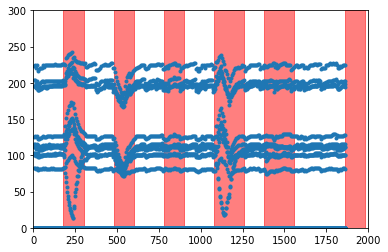

In [82]:
mask_outload_dr01 = telemetry['output-load'].notnull() & (telemetry['Producer'] == "dr01")
fig, ax = plt.subplots()
ax.plot(telemetry['time'][mask_outload_dr01], telemetry['output-load'][mask_outload_dr01], '.')
ax.axis([0, 2000, 0, 300])

ax.axvspan(3*60, 5*60, alpha=0.5, color='red')
ax.axvspan(8*60, 10*60, alpha=0.5, color='red')
ax.axvspan(13*60, 15*60, alpha=0.5, color='red')
ax.axvspan(18*60, 21*60, alpha=0.5, color='red')
ax.axvspan(23*60, 26*60, alpha=0.5, color='red')
ax.axvspan(31*60, 33*60, alpha=0.5, color='red')
#telemetry['output-load'].head()

#telemetry['output-load'].head()

In [84]:
# Group repeated time entries, and apply aggregator_funcs to overlapping fields
agg_telemetry=telemetry.groupby(telemetry['time']).aggregate(aggregator_funcs)

In [85]:
# Tag anomaly times (from casedata file)
agg_telemetry['anomaly'] = 0 # add new column
anomaly_minutes = [(5,7), (10, 12), (15,17), (20, 23), (25, 28)] # from casedata
shift = 2 # number of minutes "ground truth" is shifted
anomaly_seconds = [((i-shift) * 60, (j-shift) * 60) for i,j in anomaly_minutes] # convert to seconds

# flag entries within anomaly ranges
for i in anomaly_seconds:
    mask = agg_telemetry['time'].between(i[0], i[1])
    agg_telemetry['anomaly'] = agg_telemetry.anomaly.mask(mask, 1)

In [86]:
agg_telemetry[agg_telemetry.anomaly == 1]

,acl-in-rpf-packets,active-routes-count,backup-routes-count,bytes-received,bytes-sent,carrier-transitions,checksum-error-packets,crc-errors,deleted-routes-count,df-unreachable-packets,...,reliability,system-ram-memory,total-cpu-fifteen-minute,total-cpu-five-minute,total-cpu-one-minute,peak-input-data-rate,peak-input-packet-rate,peak-output-data-rate,peak-output-packet-rate,anomaly
time,,,,,,,,,,,,,,,,,,,,,
180.020,0.0,177.0,1.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
180.026,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,24.0,24.0,23.0,NaN,NaN,NaN,NaN,1
180.035,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,8.589935e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
180.055,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1
180.056,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,7.0,7.0,7.0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559.549,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
1559.551,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
1559.554,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1


In [87]:
agg_telemetry.head()

,acl-in-rpf-packets,active-routes-count,backup-routes-count,bytes-received,bytes-sent,carrier-transitions,checksum-error-packets,crc-errors,deleted-routes-count,df-unreachable-packets,...,reliability,system-ram-memory,total-cpu-fifteen-minute,total-cpu-five-minute,total-cpu-one-minute,peak-input-data-rate,peak-input-packet-rate,peak-output-data-rate,peak-output-packet-rate,anomaly
time,,,,,,,,,,,,,,,,,,,,,
0.000,0.0,166.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
0.054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
0.087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0
0.088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0
0.090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0


In [88]:
agg_telemetry.tail()

,acl-in-rpf-packets,active-routes-count,backup-routes-count,bytes-received,bytes-sent,carrier-transitions,checksum-error-packets,crc-errors,deleted-routes-count,df-unreachable-packets,...,reliability,system-ram-memory,total-cpu-fifteen-minute,total-cpu-five-minute,total-cpu-one-minute,peak-input-data-rate,peak-input-packet-rate,peak-output-data-rate,peak-output-packet-rate,anomaly
time,,,,,,,,,,,,,,,,,,,,,
1867.598,0.0,165.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1867.654,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,24.0,23.0,24.0,NaN,NaN,NaN,NaN,0
1867.662,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,8.589935e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1867.699,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1867.710,0.0,0.0,0.0,7.002774e+15,7.005044e+15,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [89]:
agg_telemetry[0:].to_csv('embeddings3_shifted.txt', index=False, columns=sum_cols + avg_cols + max_cols, header=False, na_rep=0, sep='\t')

In [90]:
agg_telemetry[0:].to_csv('labels3_shifted.txt', index=False, columns=['time', 'name', 'anomaly'], header=True, na_rep=0, sep='\t')